In [7]:
import matplotlib.pyplot as plt
import uproot
import mplhep as hep
import numpy as np
from scipy.stats import binned_statistic

In [8]:
#mypath = "newnew/ORG_MSELOSS/eval/test/test.root"
#mypath = "newnew/ORG_HUBERLOSS/eval/test/test.root"
#mypath = "newnew/ORG_MSELOSS_100EPOCH/eval/test/test.root"

#mypath = "newnew/CORR_HUB_CUT100/eval/test/test.root"
#mypath = "newnew/COOR_MSELOSS/eval/test/test.root"
#mypath = "newnew/COOR_HUBERLOSS/eval/test/test.root"

#mypath = "newnew/new_results_0912/test/test.root

## >> Custom Loss
mypath="newnew/run_231018-221420_cream-mushroom/eval/test/test.root"
#mypath="newnew/run_231016-162638_evasive-wren/eval/test/test.root"
## << 

#mypath = "newnew/A/eval/test/test.root"
#mypath = "newnew/B/eval/test/test.root"
#mypath = "newnew/C/eval/test/test.root"

#mypath = "/Users/jwcorp/Desktop/Nurion/test/epoch10_lr0d2_Huber_corr/eval/test/test.root"

#mypath = "LossWeight_100PXPY_1e-2/eval/test/test.root"
#mypath = "LossWeight_100PXPY_5e-3/eval/test/test.root"

In [9]:
def read_file(mypath):
    tree = uproot.open(f"{mypath}:tree")
    print(tree.keys())
    print(tree.arrays(["gen_pt"]))
    arrays = tree.arrays()
    return arrays

## 1. MET distribution

In [10]:
def draw_hist(arrays):
    plt.style.use(hep.style.CMS)  
    plt.figure(figsize=(7,6))
    bins = np.linspace(0,400)
    plt.hist(arrays['gen_pt'],bins=bins,label='Truth',histtype='step',linewidth=2)
    plt.hist(arrays['deep_pt'],bins,bins,label='TF with density weight',histtype='step',linewidth=2)
    plt.hist(arrays['puppi_pt'],bins=bins,label='PUPPI',histtype='step',linewidth=2)
    plt.yscale("log")
    plt.xlabel("$p_{T}^{Miss}$ [GeV]")
    plt.ylabel("Events")
    plt.grid('--',alpha=0.5)
    plt.legend(fontsize=15)
    plt.show()

In [11]:
arrays = read_file(mypath)
draw_hist(arrays)

FileNotFoundError: file not found

    'newnew/run_231018-221420_cream-mushroom/eval/test/test.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


## 2. MET response

In [6]:
def MET_response(arrays):
    plt.close()
    plt.style.use(hep.style.CMS)
    nbins = 20
    binnings = np.linspace(0, 400, num=nbins+1)  # create 20 bins for pt from 0 to 400 GeV
    truth_means, bin_edges, binnumber = binned_statistic(arrays["gen_pt"], arrays["gen_pt"], statistic='mean', bins=binnings, range=(0, 400))
    ml_means,  _, _ = binned_statistic(arrays["gen_pt"], arrays["deep_pt"],
                                       statistic='mean', bins=binnings, range=(0, 400))
    puppi_means, _, _ = binned_statistic(arrays["gen_pt"], arrays["puppi_pt"],
                                         statistic='mean', bins=binnings, range=(0, 400))

    # plot response
    plt.figure()
    plt.hlines(truth_means/truth_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5,
               label='Truth', linestyles='solid')
    plt.hlines(ml_means/truth_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
               label='ML', linestyles='solid')
    plt.hlines(puppi_means/truth_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5,
               label='PUPPI', linestyles='solid')
    plt.xlim(0, 400.0)
    plt.ylim(0, 1.1)
    plt.xlabel('Truth MET [GeV]')
    plt.legend(loc='lower right')
    plt.ylabel('<MET Estimation>/<MET Truth>')
    plt.show()
    
    responseCorrection_ml = np.take(truth_means/ml_means,  np.digitize(arrays["gen_pt"], binnings)-1, mode='clip')
    responseCorrection_puppi = np.take(truth_means/puppi_means, np.digitize(arrays["gen_pt"], binnings)-1, mode='clip')
    
    return responseCorrection_ml,responseCorrection_puppi
    
    

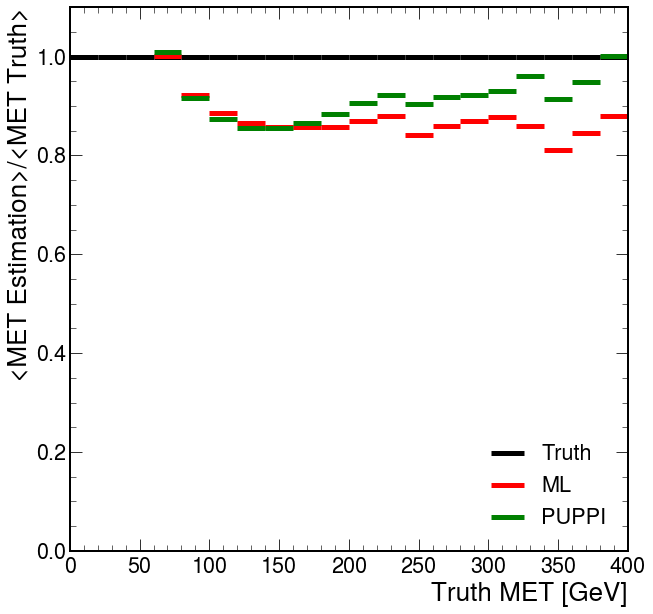

In [7]:
responseCorrection_ml, responseCorrection_puppi= MET_response(arrays)

## 3. Resolution

In [8]:
## coordinate transformation
arrays["puppi_px"] = [pt * np.cos(phi) for pt, phi in zip(arrays["puppi_pt"], arrays["puppi_phi"])]
arrays["puppi_py"] = [pt * np.sin(phi) for pt, phi in zip(arrays["puppi_pt"], arrays["puppi_phi"])]

arrays["gen_px"] = [pt * np.cos(phi) for pt, phi in zip(arrays["gen_pt"], arrays["gen_phi"])]
arrays["gen_py"] = [pt * np.sin(phi) for pt, phi in zip(arrays["gen_pt"], arrays["gen_phi"])]

arrays["deep_px"] = [pt * np.cos(phi) for pt, phi in zip(arrays["deep_pt"], arrays["deep_phi"])]
arrays["deep_py"] = [pt * np.sin(phi) for pt, phi in zip(arrays["deep_pt"], arrays["deep_phi"])]

In [9]:
# Phi calculation
import math

nbins = 20
binnings = np.linspace(0, 400, num=nbins+1)  # create 20 bins for pt from 0 to 400 GeV
phiBinnings = np.linspace(-3.15, 3.15, num=nbins+1)
truth_means, bin_edges, binnumber = binned_statistic(arrays["gen_pt"], arrays["gen_pt"], statistic='mean', bins=binnings, range=(0, 400))
ml_means,  _, _ = binned_statistic(arrays["gen_pt"], arrays["deep_pt"],
                                   statistic='mean', bins=binnings, range=(0, 400))
puppi_means, _, _ = binned_statistic(arrays["gen_pt"], arrays["puppi_pt"],
                                     statistic='mean', bins=binnings, range=(0, 400))

def resolqt(y):
    return(np.percentile(y, 84)-np.percentile(y, 16))/2.0


Phi_diff_ml = arrays["gen_phi"] - arrays["deep_phi"]
Phi_diff_ml = np.where(Phi_diff_ml < -math.pi, Phi_diff_ml + 2*math.pi, Phi_diff_ml)
Phi_diff_ml = np.where(Phi_diff_ml > math.pi, Phi_diff_ml - 2*math.pi, Phi_diff_ml)

Phi_diff_puppi = arrays["gen_phi"] - arrays["puppi_phi"]
Phi_diff_puppi = np.where(Phi_diff_puppi < -math.pi, Phi_diff_puppi + 2*math.pi, Phi_diff_puppi)
Phi_diff_puppi = np.where(Phi_diff_puppi > math.pi, Phi_diff_puppi - 2*math.pi, Phi_diff_puppi)

# compute resolutions inside all 20 bins
# the dirstribution true_pt - respCor*ml/puppi_pt should be centered at 0
bin_resolX_ml, bin_edges, binnumber = binned_statistic(arrays["gen_pt"], arrays["gen_px"] - arrays["deep_px"] * responseCorrection_ml,
                                                       statistic=resolqt, bins=binnings, range=(0, 400))
bin_resolY_ml, _, _ = binned_statistic(arrays["gen_pt"], arrays["gen_py"] - arrays["deep_py"] * responseCorrection_ml,
                                       statistic=resolqt, bins=binnings, range=(0, 400))
bin_resolPt_ml, _, _ = binned_statistic(arrays["gen_pt"], arrays["gen_pt"] - arrays["deep_pt"] * responseCorrection_ml,
                                        statistic=resolqt, bins=binnings, range=(0, 400))
bin_resolPhi_ml, bin_edgesPhi, binnumberPhi = binned_statistic(arrays["gen_phi"], Phi_diff_ml,
                                                               statistic=resolqt, bins=phiBinnings, range=(-3.15, 3.15))


bin_resolX_puppi, _, _ = binned_statistic(arrays["gen_pt"], arrays["gen_px"] - arrays["puppi_px"] * responseCorrection_puppi,
                                          statistic=resolqt, bins=binnings, range=(0, 400))
bin_resolY_puppi, _, _ = binned_statistic(arrays["gen_pt"], arrays["gen_py"] - arrays["deep_py"] * responseCorrection_puppi,
                                          statistic=resolqt, bins=binnings, range=(0, 400))
bin_resolPt_puppi, _, _ = binned_statistic(arrays["gen_pt"], arrays["gen_pt"] - arrays["deep_pt"] * responseCorrection_puppi,
                                           statistic=resolqt, bins=binnings, range=(0, 400))
bin_resolPhi_puppi, _, _ = binned_statistic(arrays["gen_phi"], Phi_diff_puppi,
                                            statistic=resolqt, bins=phiBinnings, range=(-3.15, 3.15))

# calclate the resolution "magnitude" inside all 20 bins
bin_resolXYmagnitude_ml = (bin_resolX_ml**2+bin_resolY_ml**2)**.5
bin_resolXYmagnitude_puppi = (bin_resolX_puppi**2+bin_resolY_puppi**2)**.5
bin_resolXYmagnitude_difference = bin_resolXYmagnitude_puppi - bin_resolXYmagnitude_ml

# transverse MET resolution difference
bin_resolPt_difference = bin_resolPt_puppi - bin_resolPt_ml

# compute the resolution over the entire dataset (1 bin)
average_xRes_ml = resolqt(arrays["gen_px"] - arrays["deep_px"] * responseCorrection_ml)
average_yRes_ml = resolqt(arrays["gen_py"] - arrays["deep_py"] * responseCorrection_ml)
average_ptRes_ml = resolqt(arrays["gen_pt"] -arrays["deep_pt"] * responseCorrection_ml)

average_xRes_puppi = resolqt(arrays["gen_px"] - arrays["puppi_px"] * responseCorrection_puppi)
average_yRes_puppi = resolqt(arrays["gen_py"] - arrays["puppi_py"]* responseCorrection_puppi)
average_ptRes_puppi = resolqt(arrays["gen_pt"] -arrays["puppi_pt"] * responseCorrection_puppi)

# and the resolution "magnitudes" and the corresponding difference between the puppi and ml predictions
averageXYmag_Res_puppi = (average_xRes_puppi**2+average_yRes_puppi**2)**(.5)
averageXYmag_Res_ml = (average_xRes_ml**2+average_yRes_ml**2)**(.5)

averageXYmag_Res_difference = averageXYmag_Res_puppi-averageXYmag_Res_ml
averagePt_Res_difference = average_ptRes_puppi - average_ptRes_ml
# these two similar metrics can be used to compare the performance across trainings
# for now, i will compute both

# the square root of the number of events in each bin
nEvents_inBin, _ = np.histogram(binnumber, bins=nbins, range=(1, nbins))
rootN = np.sqrt(nEvents_inBin)
nEvents_inBin_phi, _ = np.histogram(binnumberPhi, bins=nbins, range=(1, nbins))
rootN_phi = np.sqrt(nEvents_inBin_phi)
# is used to calculate the error bars for each bin = res/rootN

# locations of error bars
binWidth = binnings[1]  # =20
# +8 and +12 put the error bars slightly off the center of the horizontal lines
binCenter = binWidth/2
leftOfBinCenter = .4*binWidth  # =8
rightOfBinCenter = .6*binWidth  # =12

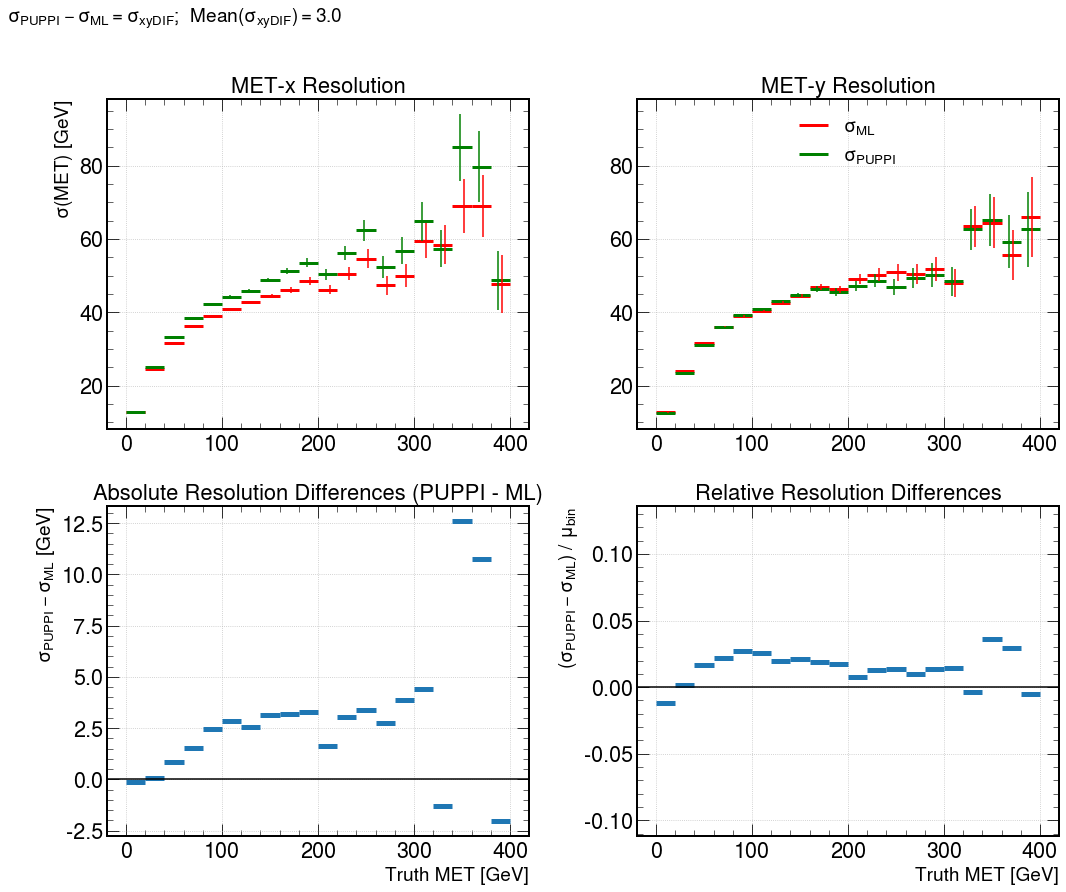

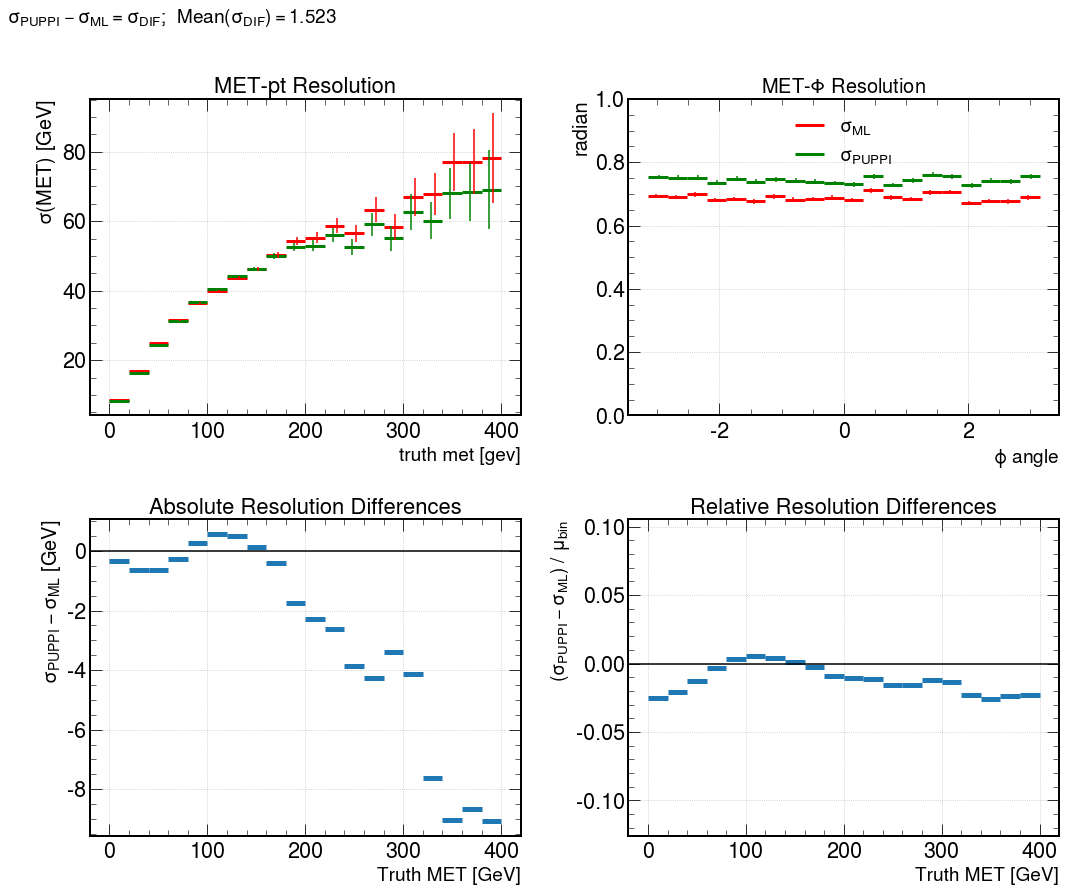

In [10]:
fig1 = plt.figure(figsize=(15, 12), tight_layout=True)
fig2 = plt.figure(figsize=(15, 12), tight_layout=True)
plt.subplots_adjust(wspace=.2,
                    hspace=0)

# plot x resolution 20 bins
ax11 = fig1.add_subplot(2, 2, 1)
ax11.hlines(bin_resolX_ml, bin_edges[:-1], bin_edges[1:], colors='r', lw=3,
            label='ML', linestyles='solid')
ax11.hlines(bin_resolX_puppi, bin_edges[:-1], bin_edges[1:], colors='g', lw=3,
            label='PUPPI', linestyles='solid')
ax11.errorbar(bin_edges[:-1]+rightOfBinCenter, bin_resolX_ml,
              yerr=bin_resolX_ml/rootN, fmt='none', color='r')
ax11.errorbar(bin_edges[:-1]+leftOfBinCenter, bin_resolX_puppi,
              yerr=bin_resolX_puppi/rootN, fmt='none', color='g')
ax11.grid()
ax11.set_ylabel(r'$\sigma(MET)$ [GeV]', fontsize=19)
ax11.set_title('MET-x Resolution', fontsize=22)

# plot y resolutions 20 bins
ax12 = fig1.add_subplot(2, 2, 2, sharey=ax11)
ax12.hlines(bin_resolY_ml, bin_edges[:-1], bin_edges[1:], colors='r', lw=3,
            label='$\\sigma_{ML}$', linestyles='solid')
ax12.hlines(bin_resolY_puppi, bin_edges[:-1], bin_edges[1:], colors='g', lw=3,
            label='$\\sigma_{PUPPI}$', linestyles='solid')
ax12.errorbar(bin_edges[:-1]+rightOfBinCenter, bin_resolY_ml,
              yerr=bin_resolY_ml/rootN, fmt='none', color='r')
ax12.errorbar(bin_edges[:-1]+leftOfBinCenter, bin_resolY_puppi,
              yerr=bin_resolY_puppi/rootN, fmt='none', color='g')
ax12.legend(loc='upper center', prop={'size': 19})
ax12.grid()
ax12.set_title('MET-y Resolution', fontsize=22)

# plot resolution XY magnitude absolute differences
ax13 = fig1.add_subplot(2, 2, 3, sharex=ax11)
ax13.hlines(bin_resolXYmagnitude_difference, bin_edges[:-1], bin_edges[1:], lw=5, linestyles='solid')
ax13.axhline(y=0, color='black', linestyle='-')
ax13.set_xlabel('Truth MET [GeV]', fontsize=19)
ax13.set_ylabel(r'$\sigma_{PUPPI} - \sigma_{ML}$ [GeV]', fontsize=19)
ax13.grid()
ax13.set_title('Absolute Resolution Differences (PUPPI - ML)', fontsize=22)

# relative differences
ax14 = fig1.add_subplot(2, 2, 4, sharex=ax12)
ax14.hlines(bin_resolXYmagnitude_difference/truth_means, bin_edges[:-1], bin_edges[1:], lw=5, linestyles='solid')
ax14.axhline(y=0, color='black', linestyle='-')
ax14.set_ylim(min(bin_resolXYmagnitude_difference/truth_means)-.1, max(bin_resolXYmagnitude_difference/truth_means)+.1)
ax14.set_xlabel('Truth MET [GeV]', fontsize=19)
ax14.set_ylabel(r'$(\sigma_{PUPPI} - \sigma_{ML})$ / $\mu_{bin}$', fontsize=19)
ax14.grid()
ax14.set_title('Relative Resolution Differences', fontsize=22)

#trainingName = path_out.split('/')[-2]
#fig1.text(0, 1.06, f'training: {trainingName}', fontsize=19)
fig1.text(0, 1.03, r'$\sigma_{PUPPI} - \sigma_{ML}=\sigma_{xyDIF}$;  $Mean(\sigma_{xyDIF})=$'+f'{round(averageXYmag_Res_difference,3)}', fontsize=19)

# plot pt resolutions 20 bins
ax21 = fig2.add_subplot(2, 2, 1)
ax21.hlines(bin_resolPt_ml, bin_edges[:-1], bin_edges[1:], colors='r', lw=3,
            label='ML', linestyles='solid')
ax21.hlines(bin_resolPt_puppi, bin_edges[:-1], bin_edges[1:], colors='g', lw=3,
            label='PUPPI', linestyles='solid')
ax21.errorbar(bin_edges[:-1]+rightOfBinCenter, bin_resolPt_ml,
              yerr=bin_resolPt_ml/rootN, fmt='none', color='r')
ax21.errorbar(bin_edges[:-1]+leftOfBinCenter, bin_resolPt_puppi,
              yerr=bin_resolPt_puppi/rootN, fmt='none', color='g')
ax21.set_xlabel('truth met [gev]', fontsize=19)
ax21.set_ylabel(r'$\sigma(MET)$ [GeV]', fontsize=20)
ax21.grid()
ax21.set_title('MET-pt Resolution', fontsize=22)

# plot phi resolutions 20 bins
ax22 = fig2.add_subplot(2, 2, 2)
ax22.hlines(bin_resolPhi_ml, bin_edgesPhi[:-1], bin_edgesPhi[1:], colors='r', lw=3,
            label='$\\sigma_{ML}$', linestyles='solid')
ax22.hlines(bin_resolPhi_puppi, bin_edgesPhi[:-1], bin_edgesPhi[1:], colors='g', lw=3,
            label='$\\sigma_{PUPPI}$', linestyles='solid')
ax22.errorbar(bin_edgesPhi[:-1]+.13, bin_resolPhi_ml,
              yerr=bin_resolPhi_ml/rootN_phi, fmt='none', color='r')
ax22.errorbar(bin_edgesPhi[:-1]+.17, bin_resolPhi_puppi,
              yerr=bin_resolPhi_puppi/rootN_phi, fmt='none', color='g')
ax22.set_ylabel('radian', fontsize=20)
ax22.set_ylim(0., 1.)
ax22.grid()
ax22.set_xlabel(r'$\phi$ angle', fontsize=19)
ax22.legend(loc='upper center', prop={'size': 19})
ax22.set_title(r'MET-$\Phi$ Resolution', fontsize=20)

# plot resolution pt absolute differences
ax23 = fig2.add_subplot(2, 2, 3, sharex=ax11)
ax23.hlines(bin_resolPt_difference, bin_edges[:-1], bin_edges[1:], lw=5, linestyles='solid')
ax23.axhline(y=0, color='black', linestyle='-')
ax23.set_xlabel('Truth MET [GeV]', fontsize=19)
ax23.set_ylabel(r'$\sigma_{PUPPI} - \sigma_{ML}$ [GeV]', fontsize=20)
ax23.grid()
ax23.set_title('Absolute Resolution Differences', fontsize=22)

# relative differences
ax24 = fig2.add_subplot(2, 2, 4, sharex=ax12)
ax24.hlines(bin_resolPt_difference/truth_means, bin_edges[:-1], bin_edges[1:], lw=5, linestyles='solid')
ax24.axhline(y=0, color='black', linestyle='-')
ax24.set_ylim(min(bin_resolPt_difference/truth_means)-.1, max(bin_resolPt_difference/truth_means)+.1)
ax24.set_xlabel('Truth MET [GeV]', fontsize=19)
ax24.set_ylabel(r'$(\sigma_{PUPPI} - \sigma_{ML})$ / $\mu_{bin}$', fontsize=19)
ax24.grid()
ax24.set_title(f'Relative Resolution Differences', fontsize=22)

#fig2.text(0, 1.06, f'training: {trainingName}', fontsize=19)
fig2.text(0, 1.03, r'$\sigma_{PUPPI} - \sigma_{ML}=\sigma_{DIF}$;  $Mean(\sigma_{DIF})=$'+f'{round(averagePt_Res_difference,3)}', fontsize=19)

fig1.savefig("XY_resolution_plots.png", bbox_inches="tight")
fig2.savefig("pt_resolution_plots.png", bbox_inches="tight")


## 4. MET-mean

In [11]:
def MET_binned_predict_mean_opaque(predict_met, predict_met2, gen_met, binning, mini, maxi, genMET_cut, corr_check, name='predict_mean.pdf'):
    plt.close("all")
    plt.style.use(hep.style.CMS)
    bin_ = int((maxi - mini)/binning)
    X_genMET = np.zeros(bin_)
    X_error = np.zeros(bin_)
    y_predict = np.zeros(bin_)
    y_error = np.zeros(bin_)

    for j in range(bin_):
        mask = (gen_met > (j * binning)) & (gen_met < ((j + 1) * binning))
        X_genMET[j] = np.mean(gen_met[mask])
        y_predict[j] = np.mean(predict_met[mask])
        X_error[j] = np.std(gen_met[mask])
        y_error[j] = np.std(predict_met[mask])

    X_genMET2 = np.zeros(bin_)
    X_error2 = np.zeros(bin_)
    y_predict2 = np.zeros(bin_)
    y_error2 = np.zeros(bin_)

    for j in range(bin_):
        mask2 = (gen_met > (j * binning)) & (gen_met < ((j + 1) * binning))
        X_genMET2[j] = np.mean(gen_met[mask2])
        y_predict2[j] = np.mean(predict_met2[mask2])
        X_error2[j] = np.std(gen_met[mask2])
        y_error2[j] = np.std(predict_met2[mask2])

    plt.errorbar(X_genMET2, y_predict2, xerr=X_error2, yerr=y_error2,
                 label='PUPPI MET', color='green', uplims=y_error2, lolims=y_error2)
    plt.errorbar(X_genMET, y_predict, xerr=X_error, yerr=y_error,
                 label='Predicted MET', color='red', uplims=y_error, lolims=y_error)

    # x = y plot
    X = np.arange(mini, maxi, binning)
    plt.plot(X, X, 'r-')
    ##

    plt.xlim(mini, maxi)
    plt.ylim(mini, maxi)
    plt.xlabel('Gen MET mean [GeV]', fontsize=16)
    #plt.ylabel('PUPPI MET mean [GeV]', fontsize = 16)
    plt.ylabel('predicted MET mean [GeV]', fontsize=16)
    plt.legend()
    #plt.savefig(name)
    plt.show(block=False)
    # plt.pause(5)
   

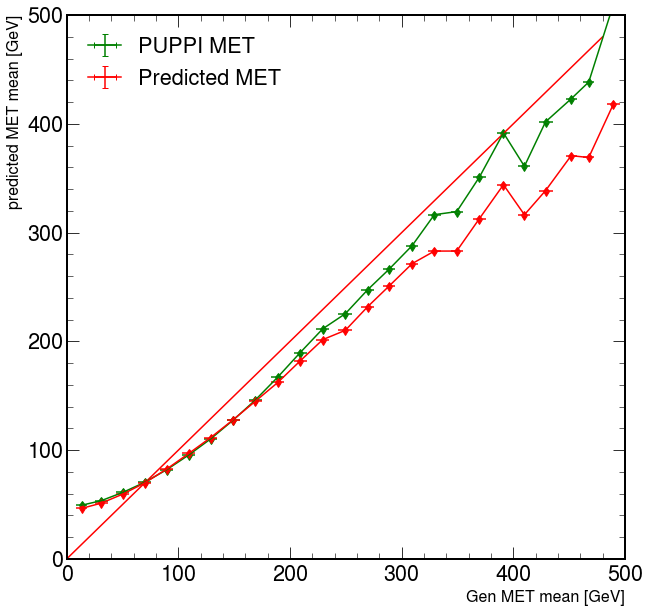

In [12]:
MET_binned_predict_mean_opaque(arrays["deep_pt"],arrays["puppi_pt"],arrays["gen_pt"],20,0,500,0,'.','metcomp.png')